# **Медицинская диагностика.**

In [397]:
import numpy as np # массивы
import matplotlib.pyplot as plt #научная графика
%matplotlib inline 
import pandas as pd #таблицы и временные ряды
import seaborn as sns # для визуализации
import sklearn #алгоритмы ML
from google.colab import files
from zipfile import ZipFile
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Инсульт является одной из ведущих причин смертей. Поэтому важной задачей является определение правильного прогноза по набору признаков. Необходимо построить модель, которая будет осуществляьб этот прогноз. 


Загрузим данные о пациентах (набор данных берется из репозитория данных Kaggle [Kaggle](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv) )

In [1]:
! pip install kaggle


Загружаем данные:

In [468]:
{"username":"volkovanastya","key":"a446185032317771b8191f0a449f3bc1"}

files.upload()
!mkdir -p ~/.Desctop
!cp kaggle.json ~/.Desctop/
!chmod 600 ~/.kaggle/archive.zip 

Saving archive.zip to archive.zip
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/archive.zip': No such file or directory


In [469]:
file_name = "archive.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [470]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

Таблица содержит данные о 5110 пациентах. Для каждого известны 12 атрибутов.
Данные содержат следующую информацию о пациентах: 

*   идентификатор
*   пол
*   возраст
*   данные об артериальной гипертензии
*   информацию о наличии сердечных заболеваний (порог сердца)
*   семейное положение
*   тип работы
*   тип проживания
*   средний уровень глюкозы в крови
*   индекс массы тела
*   статус курения
*   наличие инсульта

Посмотрим на размеры таблицы, а затем на содержание(выведем начало и конец таблицы)

In [471]:
data.shape

(5110, 12)

In [472]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


* 1) id: уникальный идентификатор
* 2) gender - пол: Male, Female или Other
* 3) age: возраст пациента
* 4) hypertension - артериальная гипертензия: 0 - если у пациента нет гипертонии, 1 - если у пациента гипертония
* 5) heart_disease: 0 - если у пациента нет сердечных заболеваний, 1 - если у пациента сердечное заболевание
* 6) ever_married: No или Yes
* 7) work_type: «children», «Govt_jov», «Never_worked», «Private» или «Self-employed»
* 8)Residence_type - Тип проживания: Rural или Urban 
* 9) avg_gluosis_level: средний уровень глюкозы в крови
* 10) bmi: индекс массы тела
* 11) Smoking_status: formerly smoked, never smoked,  smokes или Unknown
* 12) stroke - инсульт: 1 - если у пациента был инсульт, 0 - если нет

В данном наборе данных есть как числовые, так и категориальные переменные.
Целевая переменная - "stroke". Она кодируется как:

*   1 - есть инсульт
*   0 - нет инсульта

Требуется предсказать наличие у человека инсульта по его входным параметрам.

**Недостающие данные**

Посмотрим, сколько пропущенных значений в каждом столбце:

In [402]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Видим, что только в столбце bmi присутствуют пропущенные значения (NaN) - 201 нулевых значений. Пропущенные значения - числовые переменные.


Для заполнения используем функцию SimpleImputer. Заполним пропущенные значения медианой и преобразуем данные. Затем выведем информацию еще раз и увидим, что пропущенных значений теперь нет.

In [403]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
data.bmi = imputer.fit_transform(data.bmi.values.reshape(-1,1))

data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

**Описательная статистика и визуализация + выбросы(outliers)**

Сначала посмотрим на уникальность наших данных

In [404]:
data.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

Нам не нужен столбец id. Столбец состоит из уникальных данных, которые в нашей задаче для прогнозирования инсульта не нужны. Поэтому можно его убрать:

In [405]:
data.drop('id', axis=1, inplace=True)
data.columns
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Проверим наличие повторяющихся данных. Ниже видно, что повторений нет:

In [406]:
data.duplicated().sum()

0

У нас 2 признака, разделим их, чтобы было удобнее анализировать данные:

In [407]:
numerical= data.select_dtypes('number').columns
categorical = data.select_dtypes('object').columns

In [ ]:
#numerical
#categorical

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

*Числовые признаки*

Посмотрим сначала на числовые признаки.

In [408]:
data[numerical].head().T

,0,1,2,3,4
age,67.00,61.00,80.00,49.00,79.00
hypertension,0.00,0.00,0.00,0.00,1.00
heart_disease,1.00,0.00,1.00,0.00,0.00
avg_glucose_level,228.69,202.21,105.92,171.23,174.12
bmi,36.60,28.10,32.50,34.40,24.00
stroke,1.00,1.00,1.00,1.00,1.00


In [409]:
data[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,5110.0,28.862035,7.699562,10.30,23.800,28.100,32.80,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


Из таблицы, например, видно, что пропущенных значений нет ( так как мы уже заполнили их медианой), присутствует маленький возраст, который необходимо удалить.

1. age

Присутствует маленький возраст, который надо удалить. На диаграмме рассеивания видны эти выбросы.

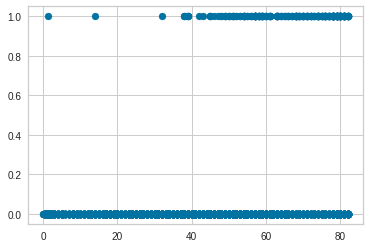

In [410]:
plt.scatter(data['age'], data['stroke'])
pass

In [411]:
data.age.sort_values()

3295     0.08
1614     0.08
3618     0.16
4021     0.16
3968     0.16
        ...  
4590    82.00
4094    82.00
2341    82.00
4716    82.00
187     82.00
Name: age, Length: 5110, dtype: float64

В столбце возраста содержатся бессмысленные значения. Мы должны убрать тех, у кого был инсульт, но возраст меньше 10 (14 и 1.32). Мы видели эти выбросы и на диаграмме рассеивания выше.


In [412]:
data[data['stroke']==1]['age'].nsmallest(10)

162     1.32
245    14.00
182    32.00
118    38.00
133    38.00
49     39.00
210    39.00
228    39.00
31     42.00
79     43.00
Name: age, dtype: float64

In [413]:
data = data.drop(index = 162)
data = data.drop(index = 245)

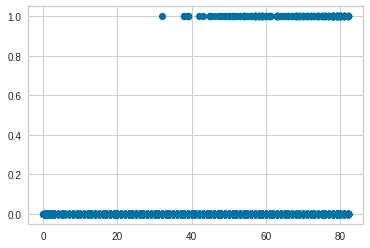

In [414]:
plt.scatter(data['age'], data['stroke'])
pass

Построим бокс-диаграмму:

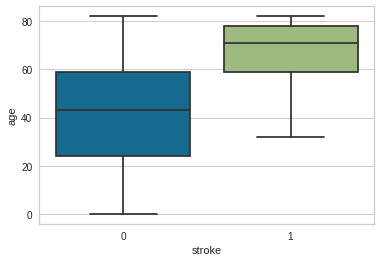

In [415]:
sns.boxplot(x="stroke", y="age", data=data)
pass

От выбросов мы уже избавились. Можно сделать вывод по этой диаграмме, что люди старше 60 склонны к инсульту 

2. hypertension


Гипертония влияет на инсульт, поэтому она может оказаться важным признаком для вашей задачи.

In [416]:
data.hypertension.value_counts()

0    4610
1     498
Name: hypertension, dtype: int64

Видим, что людей с гипертонией намного меньше. Посмотрим на зависимость инсульта от гипертонии

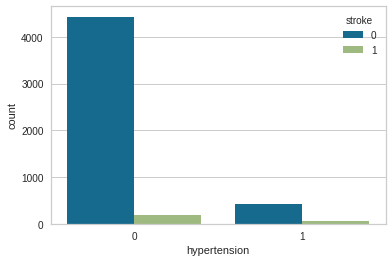

In [417]:
sns.countplot(data=data,x='hypertension',hue='stroke')


Можно заметить, что да, гипертония вызывает инсульт, но , к сожалению, данных слишком мало, чтобы увидеть явную зависимоть. Но можно сделать вывод, что у людей с гипертонией инсульт встречается чаще, то есть у людей с гипертонией риск инсульта выше.

3. heart_disease

Очевидно, что данный признак тоже должен влиять на инсульт.

In [418]:
data.heart_disease.value_counts()

0    4832
1     276
Name: heart_disease, dtype: int64

Опять видим, что людей с сердечными заболеваниями намного меньше.

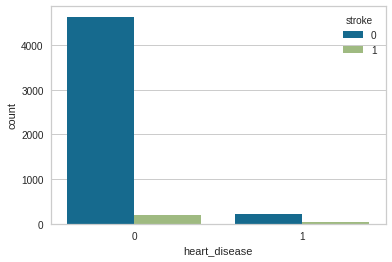

In [419]:
sns.countplot(data=data,x='heart_disease',hue='stroke')


Можно сделать такой же вывод, как и с гипертонией. То есть риск инсульта  при наличии сердечных заболеваний выше.

Гипертония и сердечные заболевания сами по себе должны влиять на инсульт, но из-за несбалансированного набора данных трудно увидеть явную зависимость.

4. avg_glucose_level

In [420]:
data.avg_glucose_level.value_counts()

93.88     6
84.10     5
72.49     5
73.00     5
83.16     5
         ..
55.83     1
162.14    1
111.77    1
90.91     1
88.02     1
Name: avg_glucose_level, Length: 3978, dtype: int64

Посмотрим на зависимость уровня глюкозы и инсульта:

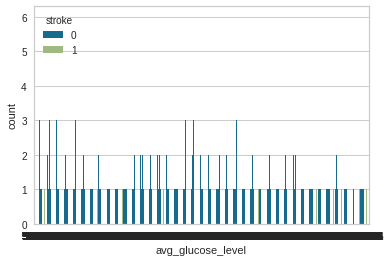

In [421]:
sns.countplot(data=data,x='avg_glucose_level',hue='stroke')


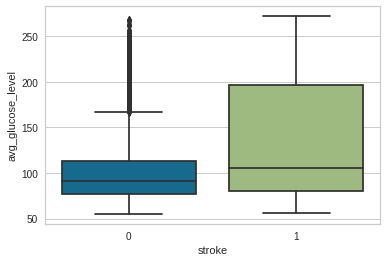

In [422]:
sns.boxplot(x="stroke", y="avg_glucose_level", data=data)
pass

Видим, что присутствуют выбросы. Можно сделать вывод, что у людей с инсультом уровень глюкозы > 100.

5. bmi

In [423]:
data.bmi.value_counts()

28.1    229
28.7     41
28.4     38
27.7     37
27.6     37
       ... 
92.0      1
13.9      1
40.6      1
52.3      1
44.1      1
Name: bmi, Length: 418, dtype: int64

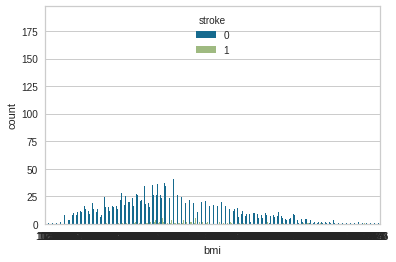

In [424]:
sns.countplot(data=data,x='bmi',hue='stroke')


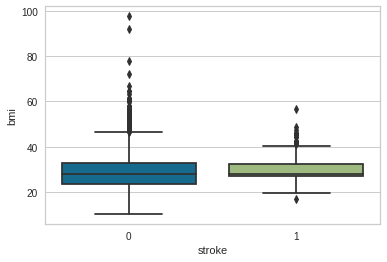

In [425]:
sns.boxplot(x="stroke", y="bmi", data=data)
pass

По диаграмме видны выбросы.

*Категориальные признаки*

In [426]:
data[categorical].head().T

,0,1,2,3,4
gender,Male,Female,Male,Female,Female
ever_married,Yes,Yes,Yes,Yes,Yes
work_type,Private,Self-employed,Private,Private,Self-employed
Residence_type,Urban,Rural,Rural,Urban,Rural
smoking_status,formerly smoked,never smoked,never smoked,smokes,never smoked


In [427]:
data[categorical].describe().T

,count,unique,top,freq
gender,5108,3,Female,2992
ever_married,5108,2,Yes,3353
work_type,5108,5,Private,2925
Residence_type,5108,2,Urban,2595
smoking_status,5108,4,never smoked,1892


1. gender

In [428]:
data.gender.unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [429]:
data['gender'].value_counts()

Female    2992
Male      2115
Other        1
Name: gender, dtype: int64

Присутствует значение "Other", оно единственное. Будем считать его некорректным. Можно просто удалить это значени ил присвоить ему значение из двух других. Присвоим ему наимолее распространенное значение - Female

In [430]:
data[data.gender=="Other"]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [431]:
data['gender'] = data['gender'].replace('Other', 'Female')

In [432]:
data['gender'].value_counts()

Female    2993
Male      2115
Name: gender, dtype: int64

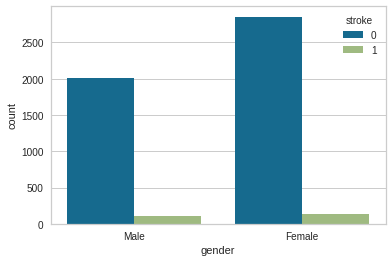

In [433]:
sns.countplot(data=data,x='gender',hue='stroke')
pass

Видим, что частота встречаемости инсульта практически никак не зависит от пола.

2. ever_married

In [434]:
data['ever_married'].value_counts()

Yes    3353
No     1755
Name: ever_married, dtype: int64

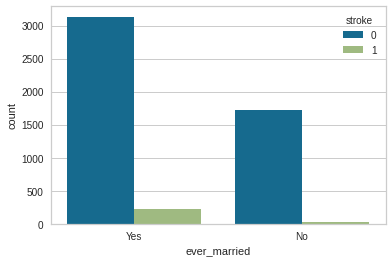

In [435]:
sns.countplot(data=data,x='ever_married',hue='stroke')
pass

Вероятность инсульта выше у тех, кто когда-либо был женат.

3. work type

In [436]:
data.work_type.value_counts()

Private          2925
Self-employed     819
children          685
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [437]:
data['work_type'].describe()

count        5108
unique          5
top       Private
freq         2925
Name: work_type, dtype: object

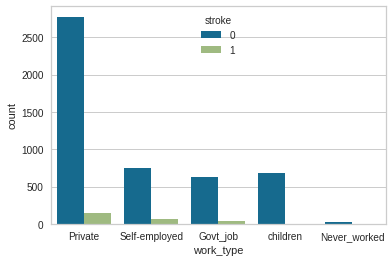

In [438]:
sns.countplot(data=data,x='work_type',hue='stroke')
pass

Вполне логичные результаты: те, кто работает/работал риск инсульта выше, а у тех, кто не работает он нулевой.

4. Residence_type

In [439]:
data.Residence_type.value_counts()

Urban    2595
Rural    2513
Name: Residence_type, dtype: int64

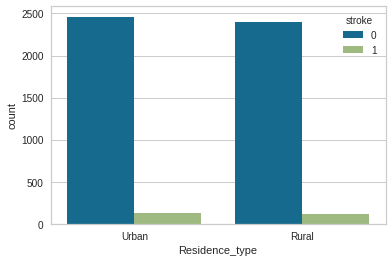

In [440]:
sns.countplot(data=data,x='Residence_type',hue='stroke')
pass

Вывод: нет никакой зависимости.

5. smoking status

In [441]:
data.smoking_status.value_counts()

never smoked       1892
Unknown            1542
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [442]:
data['smoking_status'].describe()

count             5108
unique               4
top       never smoked
freq              1892
Name: smoking_status, dtype: object

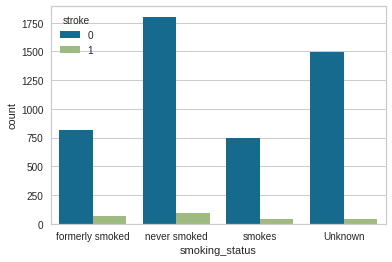

In [443]:
sns.countplot(data=data,x='smoking_status',hue='stroke')
pass

Те, кто курит/курил имеют более высокую вероятность инсульта.

**Корреляция:**

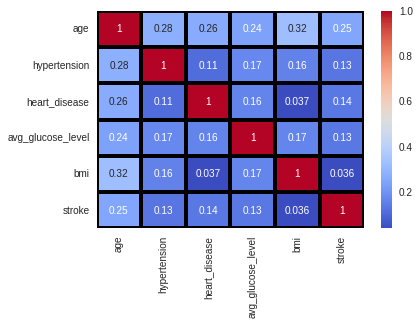

In [444]:
sns.heatmap(data.corr(), cmap = 'coolwarm', annot=True, linewidths=3, linecolor='black');

Наибольшую корреляцию составляют возраст и гипертония, индекс массы тела и возраст. А вот коэффициент между индексом массы тела и сердечными заболеваниями очень маленький. Самый маленький коэффициент - между инсультом и индексом массы тела.

**Целевая переменная**

In [445]:
data.stroke.value_counts()

0    4861
1     247
Name: stroke, dtype: int64

In [446]:
data.stroke.value_counts(normalize=True)*100

0    95.164448
1     4.835552
Name: stroke, dtype: float64

Почти у 95% экземпляров нашей целевой переменной нет инсульта(4861 человек). У 5% есть инсульт(249 человек).

Можно сделать вывод, что мы имеем дело с несбалансированными данными. 

In [447]:
data['stroke'].describe()

count    5108.000000
mean        0.048356
std         0.214537
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: stroke, dtype: float64

Для наглядности несбалансированности данных, построим диаграмму:

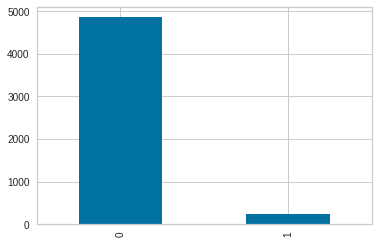

In [448]:
data['stroke'].value_counts().plot(kind = 'bar');

**Графики зависимостей между каждой парой признаков**

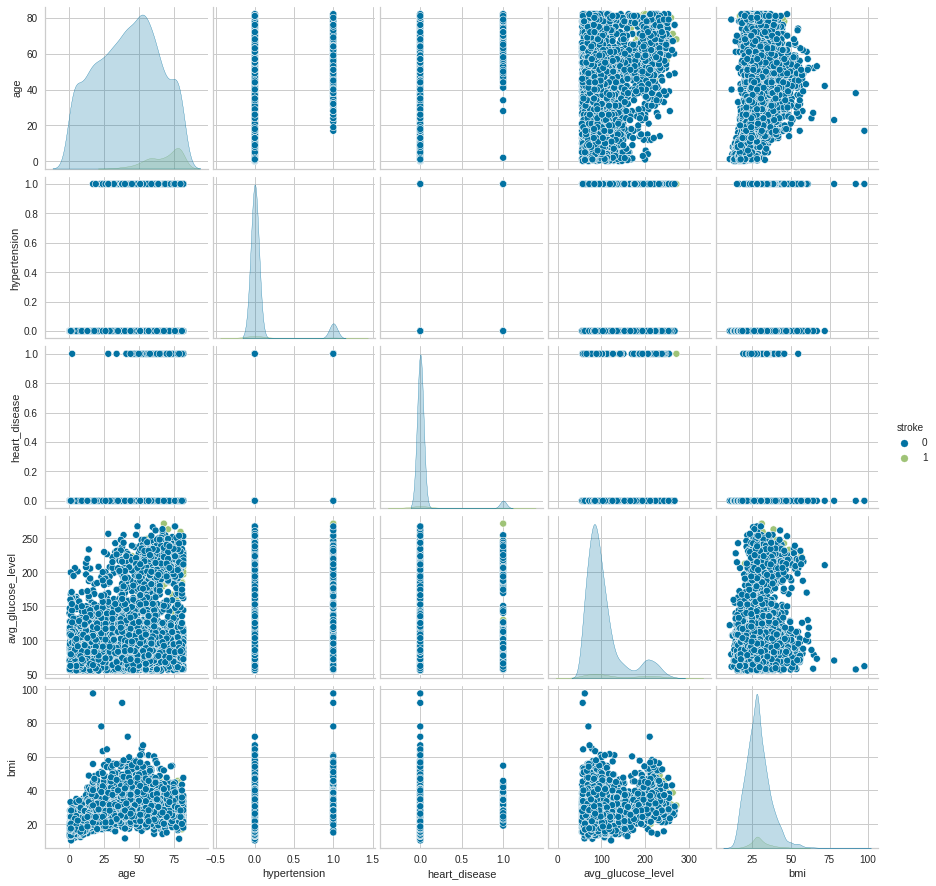

In [449]:
sns.pairplot(data,hue='stroke');

**Обработка категориальных признаков**

One-Hot Encoding  - кодирует значения как двоичный векторный массив.

In [450]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [451]:
delete = data.select_dtypes(include="object").columns
delete

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

Выполняем бинаризацию с помощью функции get_dummies:

In [452]:
data = pd.get_dummies(data, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status',], drop_first=True)

In [453]:
data

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,1,1,0,1,0,0,1,1,0,0
1,61.0,0,0,202.21,28.1,1,0,1,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.5,1,1,1,0,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.4,1,0,1,0,1,0,0,1,0,0,1
4,79.0,1,0,174.12,24.0,1,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.1,0,0,1,0,1,0,0,1,0,1,0
5106,81.0,0,0,125.20,40.0,0,0,1,0,0,1,0,1,0,1,0
5107,35.0,0,0,82.99,30.6,0,0,1,0,0,1,0,0,0,1,0
5108,51.0,0,0,166.29,25.6,0,1,1,0,1,0,0,0,1,0,0


**Предварительная обработка данных**

In [454]:
X = data.drop('stroke',axis=1)
y = data['stroke']

In [455]:
X

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,1,0,1,0,0,1,1,0,0
1,61.0,0,0,202.21,28.1,0,1,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.5,1,1,0,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.4,0,1,0,1,0,0,1,0,0,1
4,79.0,1,0,174.12,24.0,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.1,0,1,0,1,0,0,1,0,1,0
5106,81.0,0,0,125.20,40.0,0,1,0,0,1,0,1,0,1,0
5107,35.0,0,0,82.99,30.6,0,1,0,0,1,0,0,0,1,0
5108,51.0,0,0,166.29,25.6,1,1,0,1,0,0,0,1,0,0


In [456]:
y

0       1
1       1
2       1
3       1
4       1
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 5108, dtype: int64

**Деление выборки на обучающую и тестовую**

Используем stratify, чтобы пропорция значений в выборке была как в параметре y

In [457]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

**Нормализация**

In [458]:
X_train_scaled = MinMaxScaler().fit_transform(X_train)
X_test_scaled = MinMaxScaler().fit_transform(X_test)

**KNeighborsClassifier**

In [459]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import accuracy_score, log_loss


In [463]:
accuracy_train = []
accuracy_test = []
loss_train = []
loss_test = []
error_rate_train = []
error_rate_test = []
neighbors = []

In [464]:
for i in range(2,90, 4):
    model = KNeighborsClassifier(algorithm='auto', n_neighbors=i, n_jobs=-1)
    model.fit(X_train_scaled, y_train)
    
    neighbors.append(i)
    
    accuracy_train.append(accuracy_score(y_train, model.predict(X_train_scaled)))
    accuracy_test.append(accuracy_score(y_test, model.predict(X_test_scaled)))

    error_rate_train.append(1-accuracy_score(y_train, model.predict(X_train_scaled)))
    error_rate_test.append(1-accuracy_score(y_test, model.predict(X_test_scaled)))

    loss_train.append(log_loss(y_train, model.predict_proba(X_train_scaled)))
    loss_test.append(log_loss(y_test, model.predict_proba(X_test_scaled)))


Text(0, 0.5, 'Точность')

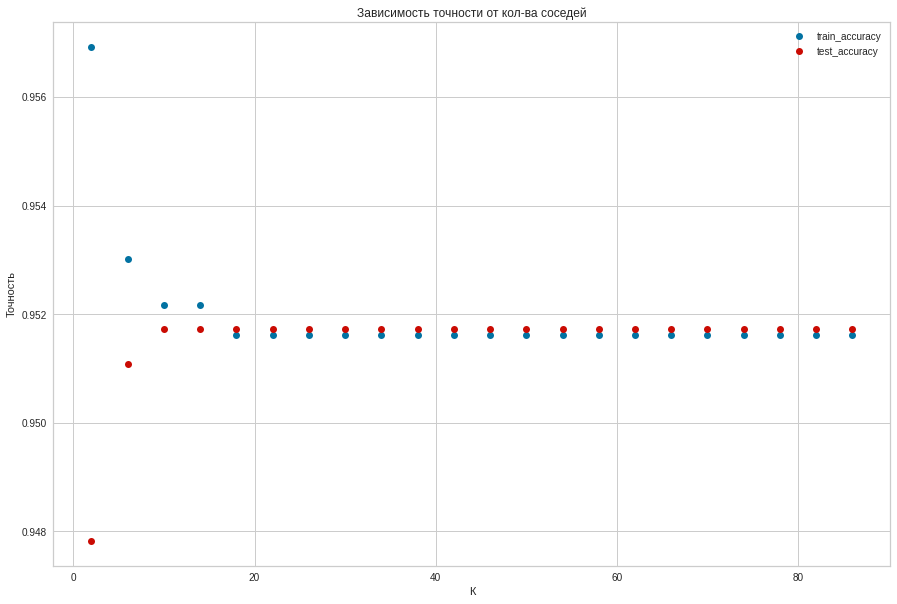

In [465]:
plt.figure(figsize=(15,10))

plt.plot(neighbors, accuracy_train, 'bo', neighbors, accuracy_test, 'ro')
plt.legend(['train_accuracy', 'test_accuracy'])
plt.title('Зависимость точности от кол-ва соседей')
plt.xlabel('К')
plt.ylabel('Точность')

При k = 10 точность на тестовой выборке достигает максимального значения и перестает изменяться, значение колеблется в районе чуть ниже 95.2%

Text(0, 0.5, 'Кросс-энтропия')

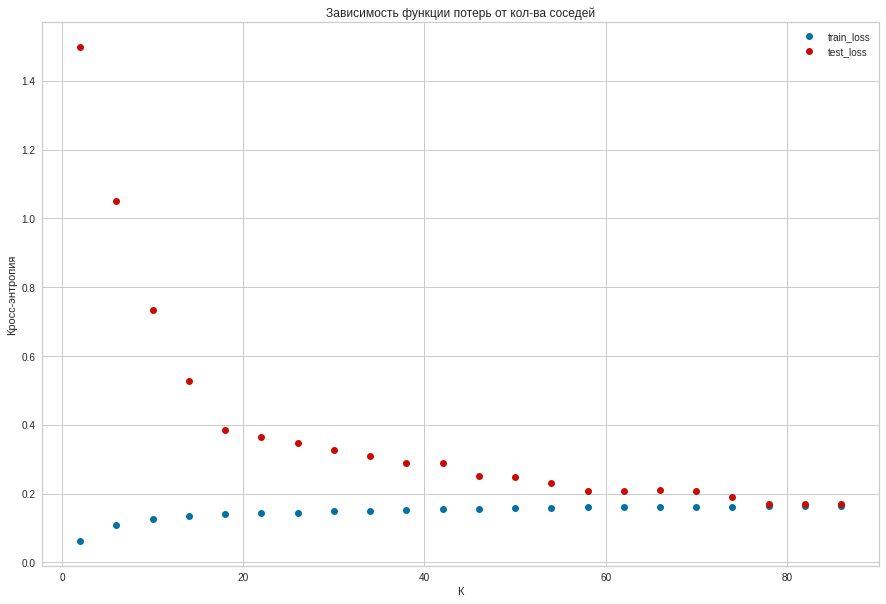

In [466]:
plt.figure(figsize=(15,10))

plt.plot(neighbors, loss_train, 'bo', neighbors, loss_test, 'ro')
plt.legend(['train_loss', 'test_loss'])
plt.title('Зависимость функции потерь от кол-ва соседей')
plt.xlabel('К')
plt.ylabel('Кросс-энтропия')

Функции потерь по выборкам приближается к значению 0.19

Text(0, 0.5, 'Уровень ошибок')

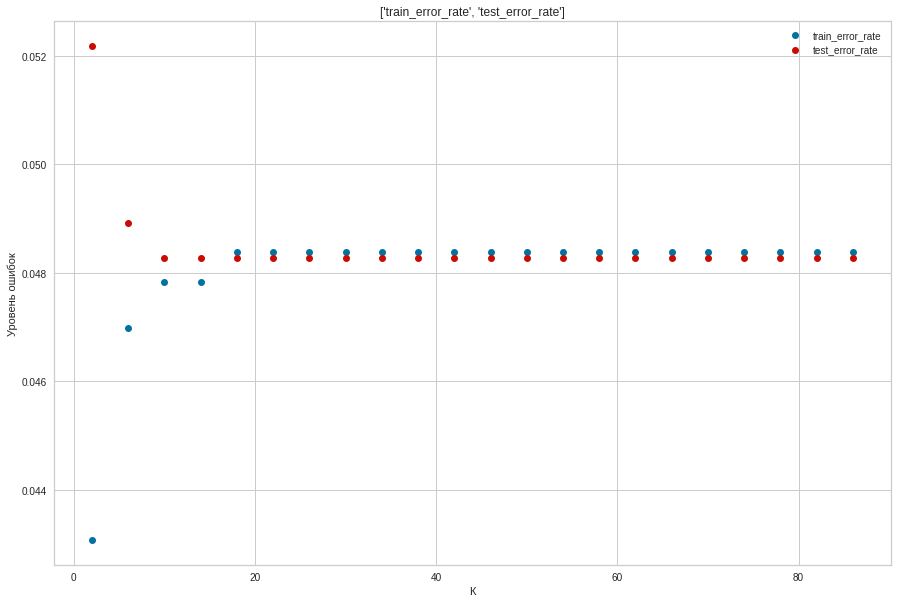

In [467]:
plt.figure(figsize=(15,10))

plt.plot(neighbors, error_rate_train, 'bo', neighbors, error_rate_test, 'ro')
plt.legend(['train_error_rate', 'test_error_rate'])
plt.title(['train_error_rate', 'test_error_rate'])
plt.xlabel('К')
plt.ylabel('Уровень ошибок')